# Rare variants

This analysis aimed to answer the following research question: 

**What is the distribution of rare variants within the different genes, and how do these distributions vary within African ethnolinguistic subpopulations?**

To answer this question, the following steps were performed: 

1. Genetic variants were segmented into distinct bins based on population frequency. 
2. Variant data was grouped by frequency bin and gene. The distribution of variant frequencies within the different genes was visualised using a bar plot with the grouped data as input. 
3. Variant data was grouped by frequency bin and ethnolinguistic population group. The distribution of variant frequencies within the different population groups was visualised using a bar plot with the grouped data as input. 
4. The amount and percentage of rare variants within each ethnolinguistic population was calculated, along with the overall amount and percentage of rare variants across all populations.

## Imports

Import relevant libraries and packages

In [1]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions

## Data loading

Import the processed African variant count data from the `Data/Processed/IH_allele_counts.csv` file. This file includes the following information:

* `ID`: A unique variant identifier.
* `VAR_NAME`: The non-unique name of the variant.
* `POS`: The nucleotide position at which the genetic variant is located within the genome.
* `ALT` and `REF`: An allele refers to the different forms of a specific variant that can exist at a particular genetic position. For each variant, there are two alleles, the normal form known as the reference allele (REF), and the altered form known as the alternate allele (ALT). These alleles define the genetic variation at a given position.
* `GENE`: The gene in which the variant is located.
* `SUB_POP`: The African ethnolinguistic subpopulation from which the genetic data sample originated.
* `IH_ALT_CTS`: This shows how many times each genetic variant's alternate allele (ALT) appears in all the samples of a population.
* `IH_TOTAL_CTS`: This provides the overall count of all genetic variants' alleles (both REF and ALT) mentioned in the data.
* `IH_REF_CTS`: This shows how many times each genetic variant's reference allele form (REF) appears in all the samples of a population.
* `REG`: The regional classification of the sample's ethnolinguistic group. The possible regions are:
  - Central Africa (CA)
  - Southern Africa (SA)
  - Eastern Africa (EA)
  - Western Africa (WA)
* `IH_AF`: The frequency of the variant's alternate allele in all samples of the population.
* `VARIANT_TYPE`: The type of variant. The possible types are:
    - INDEL
    - SNP

In [2]:
ih_allele_counts = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
)

ih_allele_counts.head(5)

,ID,VAR_NAME,VARIANT_TYPE,CHROM,POS,REF,ALT,GENE,SUB_POP,REG,IH_REF_CTS,IH_ALT_CTS,IH_TOTAL_CTS,IH_AF
0,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Bantu Kenya,EA,20,0,20,0.0
1,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Yoruba,WA,276,0,276,0.0
2,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,San,SA,12,0,12,0.0
3,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Mende,WA,166,0,166,0.0
4,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Mbuti Pygmy,CA,24,0,24,0.0


## Analysis and visualisation

### Segment allele frequencies into quantiles

Due to the wide range of allele frequency values, the frequencies were segmented into quantiles. This segmentation allows for better comparison of data across different allele frequency ranges.

In [3]:
# Define the bins and labels for quantile segmentation of allele frequencies
bins = [0, 0.001, 0.01, 0.1, 1.01]
labels = [
    "Frequency < 0.1%",
    "0.1% >= Frequency < 1%",
    "1% >= Frequency < 10%",
    "10% >= Frequency < 100%",
]

# Segment allele frequencies into quantiles based on the defined bins and labels
ih_allele_counts["QUANTILE"] = pd.cut(
    ih_allele_counts["IH_AF"], bins, labels=labels, right=False, include_lowest=True
)

# Display the first 5 rows of the updated DataFrame to verify the quantile segmentation
ih_allele_counts.head(5)

,ID,VAR_NAME,VARIANT_TYPE,CHROM,POS,REF,ALT,GENE,SUB_POP,REG,IH_REF_CTS,IH_ALT_CTS,IH_TOTAL_CTS,IH_AF,QUANTILE
0,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Bantu Kenya,EA,20,0,20,0.0,Frequency < 0.1%
1,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Yoruba,WA,276,0,276,0.0,Frequency < 0.1%
2,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,San,SA,12,0,12,0.0,Frequency < 0.1%
3,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Mende,WA,166,0,166,0.0,Frequency < 0.1%
4,110148882_C_CT,chr13:110148882C-CT,INDEL,13,110148882,C,CT,COL4A1,Mbuti Pygmy,CA,24,0,24,0.0,Frequency < 0.1%


### Gene variant frequency distributions

Determine the number of variants within each frequency quantile for each gene

In [4]:
# Select "Recent African" allele frequency data
ih_afr_genes = ih_allele_counts[((ih_allele_counts.REG == "Recent African"))]

# Remove variants with an alternate allele count of 0 as they are not considered
ih_afr_genes = ih_afr_genes[ih_afr_genes.IH_ALT_CTS > 0]

# Count the total number of unique variants in the dataset
all_variants = ih_afr_genes.ID.nunique()
print(f"Total variant count: {all_variants}")

# Count the number of variants within each quantile for each gene
variant_distr_data = (
    ih_afr_genes[["GENE", "QUANTILE", "VAR_NAME"]]
    .groupby(["GENE", "QUANTILE"])
    .count()
    .reset_index()
    .rename(columns={"VAR_NAME": "VAR_COUNT"})
)

# Print the DataFrame showing the variant count per gene and quantile
print(f"Total variant count per gene: \n{variant_distr_data}")

Total variant count: 8870
Total variant count per gene: 
      GENE                 QUANTILE  VAR_COUNT
0      AGT         Frequency < 0.1%        158
1      AGT   0.1% >= Frequency < 1%        178
2      AGT    1% >= Frequency < 10%         94
3      AGT  10% >= Frequency < 100%         71
4    AP4B1         Frequency < 0.1%         61
5    AP4B1   0.1% >= Frequency < 1%         44
6    AP4B1    1% >= Frequency < 10%         39
7    AP4B1  10% >= Frequency < 100%          9
8    CARD8         Frequency < 0.1%        543
9    CARD8   0.1% >= Frequency < 1%        690
10   CARD8    1% >= Frequency < 10%        402
11   CARD8  10% >= Frequency < 100%        463
12     CAT         Frequency < 0.1%        223
13     CAT   0.1% >= Frequency < 1%        211
14     CAT    1% >= Frequency < 10%        100
15     CAT  10% >= Frequency < 100%         85
16  COL4A1         Frequency < 0.1%       1142
17  COL4A1   0.1% >= Frequency < 1%       1271
18  COL4A1    1% >= Frequency < 10%        897
19 

Set plot parameters

In [5]:
plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Generate a histogram to visualise the variant frequency distribution for each gene

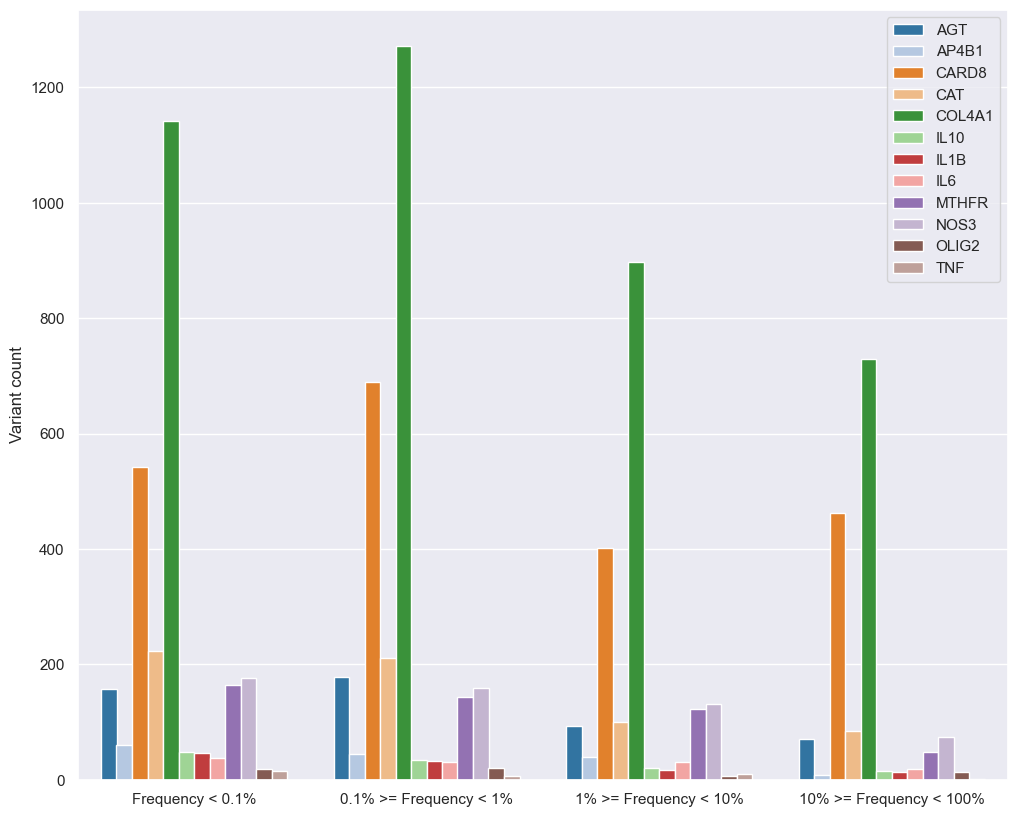

In [6]:
# Set the default figure size for plots
sns.set(rc={"figure.figsize": (12, 10)})
# Set the color palette for the plot
palette = sns.set_palette("tab20", 12)

# Create a barplot to visualize variant counts across different quantiles for each gene
sns.barplot(
    data=variant_distr_data, x="QUANTILE", y="VAR_COUNT", hue="GENE", palette=palette
)

# Customize the legend of the plot
plt.legend(
    loc="upper right",
    frameon=True,
    title=None,
)

# Remove the x-axis label
plt.xlabel(None)

# Set the y-axis label
plt.ylabel("Variant count")

# Remove the plot title
plt.title(None)

# Save the plot as a high-resolution PNG file
plt.savefig(
    r"..\Results\Figures\3a-Gene_variant_frequencies.png", dpi=1200, bbox_inches="tight"
)

# Display the plot
plt.show()

### Prevalence of rare variants in Africans overall

How many variants occurred at a rare variant frequency of below 0.01 (1%) in Africans overall?

In [7]:
rare_variants = ih_afr_genes[ih_afr_genes.IH_AF < 0.01].ID.nunique()
rare_percentage = rare_variants / all_variants * 100

print(f"In Africans, {rare_variants} variants ({rare_percentage}%) were rare overall")

In Africans, 5457 variants (61.52198421645998%) were rare overall


How many of the rare variants were potentially novel?

In [8]:
rare_novel_variants = ih_afr_genes[
    (ih_afr_genes.IH_AF < 0.001) & ~(ih_afr_genes.VAR_NAME.str.contains("rs"))
].ID.nunique()

print(f"Of the rare variants in Africans overall, {rare_novel_variants} were potentially novel")

Of the rare variants in Africans overall, 1114 were potentially novel


### Distribution of variant frequencies in African ethnolinguistic subpopulations

Determine the number of variants within each frequency quantile for each subpopulation

In [9]:
# Filter out aggregated "Recent African" data
ih_afr_subpops = ih_allele_counts[~(ih_allele_counts.REG == "Recent African")]

# Remove variants with an alternate allele count of 0 as they are not considered
ih_afr_subpops = ih_afr_subpops[ih_afr_subpops.IH_ALT_CTS > 0]

# Group data by frequency quantile and subpopulation
ih_afr_subpops_binned_grouped = (
    functions.group_and_count(
        data=ih_afr_subpops[["QUANTILE", "SUB_POP", "ID"]],
        group_columns=["QUANTILE", "SUB_POP"],
    )
    .reset_index()
    .rename(columns={"ID": "COUNT"})
)

# Pivot data before plotting
ih_afr_subpops_binned_pivot = ih_afr_subpops_binned_grouped.pivot(
    index="SUB_POP", columns="QUANTILE", values="COUNT"
)

ih_afr_subpops_binned_pivot

QUANTILE,Frequency < 0.1%,0.1% >= Frequency < 1%,1% >= Frequency < 10%,10% >= Frequency < 100%
SUB_POP,,,,
Bantu Kenya,0,0,657,1721
Bantu South Africa,0,0,736,1633
Biaka Pygmy,0,0,1551,1593
Esan,0,1188,1640,1534
Luhya,0,1125,1988,1522
Mandenka,0,0,1174,1619
Mandinka,0,1539,1679,1540
Mbuti Pygmy,0,0,1013,1584
Mende,0,954,1953,1514


Generate a barplot to visualise variant frequency distribution for each subpopulation

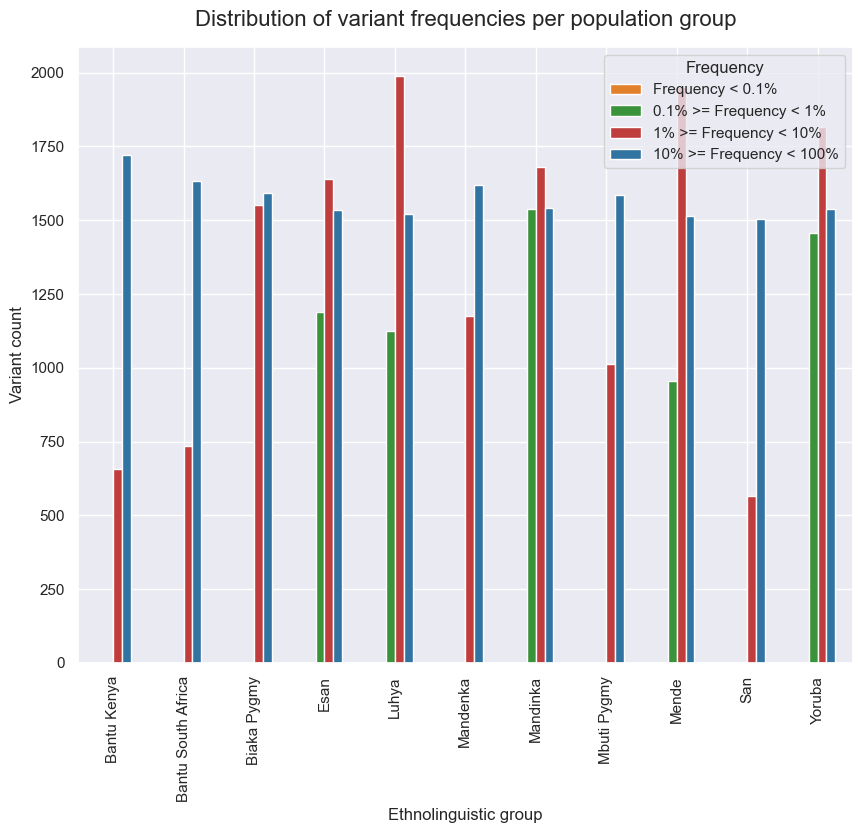

In [17]:
# Set the default figure size for plots
sns.set(rc={"figure.figsize": (10, 8)})

# Set the color palette for the plot
colors = ["#E1812C", "#3A923A", "#C03D3E", "#3274A1"]
palette = sns.set_palette(colors)

# Create a bar plot to visualize variant counts for different ethnolinguistic groups
ih_afr_subpops_binned_pivot.plot.bar(logy=False, color=palette)

# Set the x-axis label
plt.xlabel("Ethnolinguistic group")

# Set the y-axis label
plt.ylabel("Variant count")

# Customize the legend of the plot
plt.legend(loc="upper right", frameon=True, title="Frequency")

# Set the plot title with specific formatting
plt.title(
    "Distribution of variant frequencies per population group",
    size=constants.LARGEST_FONT,
    pad=15,
)

# Save the plot as a high-resolution PNG file
plt.savefig(
    r"..\Results\Figures\3b-Population_variant_frequencies.png",
    dpi=1200,
    bbox_inches="tight",
)

# Display the plot
plt.show()

From the figure above, it is evident that certain African subpopulations exhibit a higher prevalence of rare variants compared to others. Notably, the Mandinka population shows a significant concentration of variants with frequencies ranging from 0.1% (inclusive) to just under 1% (exclusive).

### Prevalence of rare variants in African ethnolinguistic subpopulations

What percentage of the variants were rare, occuring at frequency below 0.01 (1%) in a particular subpopulation?

In [11]:
rare_variants = ih_afr_subpops[ih_afr_subpops["IH_AF"] < 0.01].ID.nunique()
all_variants = ih_afr_subpops.ID.nunique()
rare_variant_percentage = (rare_variants / all_variants) * 100
print(f"{rare_variant_percentage}% of the variants were rare in at least one African subpopulation group")

51.7587373167982% of the variants were rare in at least one African subpopulation group


51.76% variants detected in the African populations occurred at a frequency below 1% in a particular population. Note, that this figure does not represent the percentage of rare variants in the broader African population. Some of these variants, although rare for a particular African subpopulation, may be common in Africans overall.